In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import uproot as ur,glob, os,awkward as ak


plt.rcParams["figure.figsize"] = (10, 8)

In [58]:
events={}; events_lead={}
import pickle
for A in "D C Fe Pb".split():
    for flav in "pi+", "pi-":
        f=f"beagle_output_pi_p/e{A}_{flav}_p.pkl"
        with open(f, "rb") as f:
            events[(A, flav)],  events_lead[(A, flav)]= pickle.load(f)
        print(f"parsed {A}, leading {flav}, {len(events[(A,flav)])} pairs, {len(events_lead[(A,flav)])} leading")

parsed D, leading pi+, 1496849 pairs, 2242241 leading
parsed D, leading pi-, 1515545 pairs, 1295584 leading
parsed C, leading pi+, 1431455 pairs, 2482078 leading
parsed C, leading pi-, 1553460 pairs, 1525607 leading
parsed Fe, leading pi+, 1817209 pairs, 2195905 leading
parsed Fe, leading pi-, 1688756 pairs, 1340694 leading
parsed Pb, leading pi+, 909924 pairs, 1851177 leading
parsed Pb, leading pi-, 1018261 pairs, 1150911 leading


In [65]:
def process(df):
    pi=np.pi
    df['dphi']=df.eval(f"phi1-phi2-(phi1-phi2>{np.pi})*{2*pi}+(phi1-phi2<-{np.pi})*{2*np.pi}")
    df['dy']=df.eval("y1-y2")
    Mp=0.9383
    df['nu']=df.eval(f"Q2/(x*2*{Mp})")
    df['W']=df.eval(f"sqrt({Mp**2}+2*{Mp}*nu-Q2)")
def process_lead(df):
    Mp=0.9383
    df['nu']=df.eval(f"Q2/(x*2*{Mp})")
    df['W']=df.eval(f"sqrt({Mp**2}+2*{Mp}*nu-Q2)")
    
for A in "D C Fe Pb".split():
    for flav in "pi+", "pi-":
        process(events[(A, flav)])
        process_lead(events_lead[(A,flav)])

In [99]:
deg=np.pi/180
#all_data['all'][0]['D'].C
def getPrediction(q_add=None, q_add_lead=None, flav="pi+"):
    q=f"pT1>0.25 and pT2>0.25 and Q2>1 and nu>2.2 and nu<4.2 and W>2"
    q+=f" and thetalab1>10*{deg} "
    q+=f" and thetalab2>10*{deg} and p2>0.35"
    #if flav=="pi-":
    #    q+=f" and ((thetalab1>25*{deg} and p1>0.7) or (thetalab1>30*{deg} and p1>0.5) or (thetalab1>40*{deg} and p1>0.35))"
    q+=f" and z1>0.5"
    q+=f" and z2>0.05 and z2<0.45"
    q_lead=f"pT1>0.25 and Q2>1 and nu>2.2 and nu<4.2 and W>2 and thetalab1>10*{deg}"
    if q_add is not None:
        q+= " and " + q_add
    if q_add_lead is not None:
        q_lead+= " and " + q_add_lead
        
    colors='tab:red tab:blue tab:orange tab:green'.split()
    results={}
    for i,A in enumerate("D C Fe Pb".split()):
        if (A, flav) not in events:
            continue
        #plt.hist(events[A].query(q).dphi, bins=np.linspace(-np.pi,np.pi, 17), density=False, histtype='step', 
        #         label=A, color=colors[i])
        y,x=np.histogram(abs(events[(A, flav)].query(q).dphi), bins=np.linspace(0,np.pi, 9))
        print(y)
        bc=(x[1:]+x[:-1])/2
        n_lead=len(events_lead[(A, flav)].query(q_lead))

        width=np.sqrt(np.sum(y*(bc-np.pi)**2)/np.sum(y))
        
        #width=np.sqrt(np.sum(y*(bc-np.pi)**2)/np.sum(y))
        if i==0:
            norm = 2*np.pi/8*sum(y/n_lead)
            width_D=width
        
        #print(width, np.sqrt(width**2-width_D**2))
        
        C=y/n_lead/norm
        dCstat = np.sqrt(y)/n_lead/norm
        phi=bc
        phi_low=x[:-1]
        phi_up=x[1:]

        dwidth=np.sqrt(sum(dCstat**2*(((phi-np.pi)**2-width**2)/sum(C))**2))/(2*width)
        print(A, "%.3f"%width, "+-", "%.3f"%dwidth)
        
        bc=list(bc)+list(reversed(np.pi*2-bc))
        y=np.array(list(y)+list(reversed(y)))

        
        plt.fill_between(bc, (y-np.sqrt(y))/n_lead/norm,  (y+np.sqrt(y))/n_lead/norm,label="BeAGLE "+A, color=colors[i], alpha=0.5)
        results[A]=pd.DataFrame({'C':C, 'dCstat':dCstat, "phi":phi,"phi_low":phi_low, "phi_up": phi_up})
        #results[A]['R'] = results[A]['C']/results['D']['C']
        #results[A]['dRstat'] = results[A]['R']*np.hypot(results[A]['dCstat']/results[A]['C'],results['D']['dCstat']/results['D']['C'])
    plt.legend()
    plt.title(f"$\\pi^{flav[2]}p$")
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.ylabel("correlation")
    plt.ylim(0)
    plt.show()
    return results
all_BeAGLE={}

[  866  1020  1360  2511  4848 11578 25790 44769]
D 0.800 +- 0.003
[ 1966  2211  2871  4414  8083 16854 34773 58890]
C 0.896 +- 0.002
[ 4049  4398  5329  7256 11843 20525 36953 56048]
Fe 1.073 +- 0.002
[ 5353  5905  6868  8908 13056 20665 33102 46535]
Pb 1.201 +- 0.002


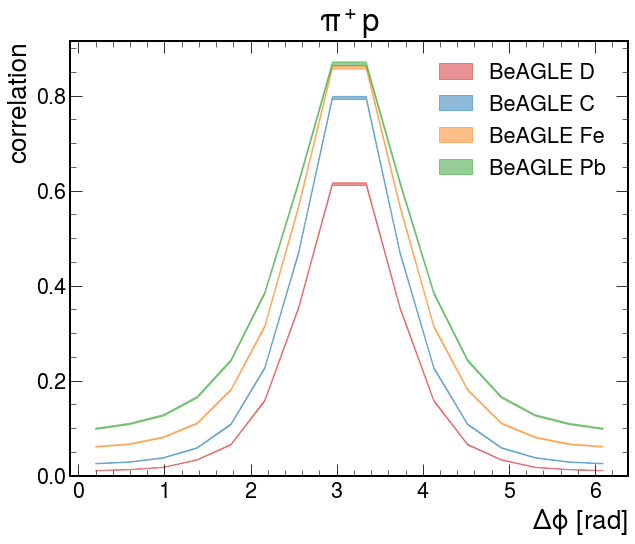

dY bins
[  32   29   29   77  137  427 1568 4449]
D 0.575 +- 0.009
[  69   73   89  153  255  716 2162 5107]
C 0.688 +- 0.009
[ 127  165  181  252  491 1092 2671 5230]
Fe 0.823 +- 0.009
[ 131  155  220  345  525 1145 2416 4122]
Pb 0.900 +- 0.009


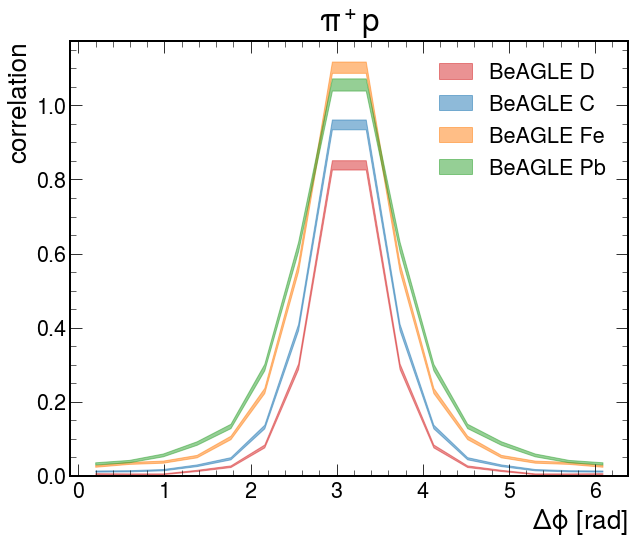

[  474   564   795  1448  2917  7875 19025 33252]
D 0.747 +- 0.003
[ 1179  1336  1787  2771  5230 11597 25229 43784]
C 0.852 +- 0.003
[ 2382  2539  3145  4421  7382 13554 25409 39295]
Fe 1.025 +- 0.003
[ 2907  3242  3858  5134  7788 12833 21705 31232]
Pb 1.145 +- 0.003


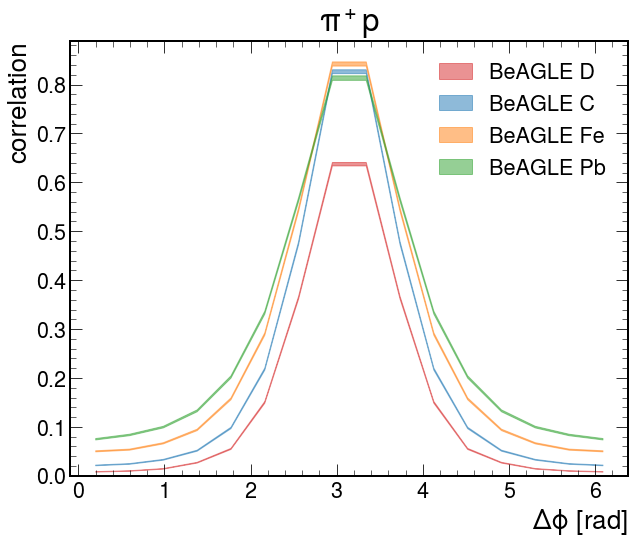

[ 355  418  526  971 1777 3248 5164 7036]
D 1.009 +- 0.006
[ 710  792  987 1487 2589 4525 7364 9974]
C 1.073 +- 0.005
[ 1520  1669  1981  2556  3946  5853  8818 11471]
Fe 1.237 +- 0.005
[ 2279  2460  2750  3393  4702  6635  8920 11103]
Pb 1.359 +- 0.004


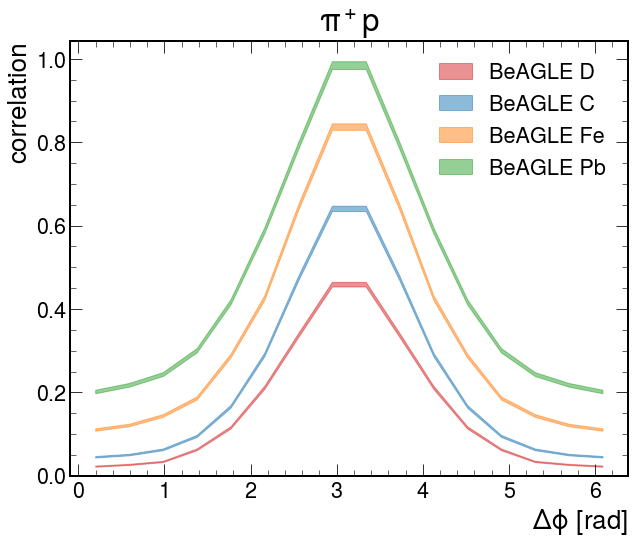

pT1 bins
[ 429  493  685 1353 2722 5218 7194 8629]
D 1.012 +- 0.005
[  851   967  1228  1980  3640  6400  9018 10940]
C 1.098 +- 0.005
[ 1602  1798  2106  2784  4631  6891  9342 11181]
Fe 1.252 +- 0.004
[ 2171  2465  2724  3384  4713  6596  8591 10229]
Pb 1.371 +- 0.004


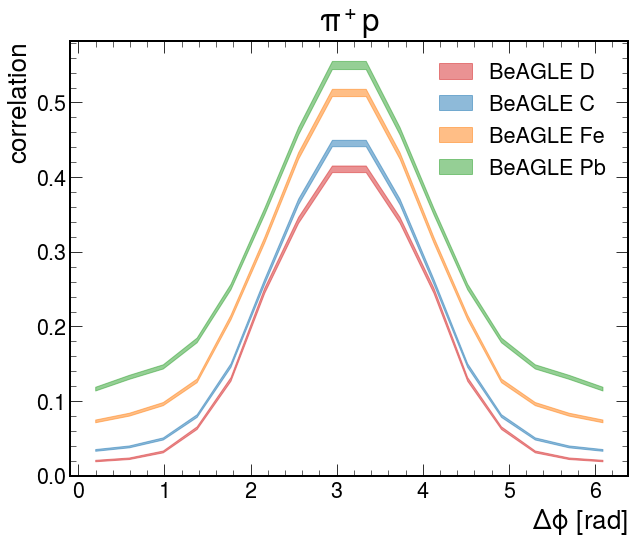

[  292   331   446   718  1441  4794 13000 19208]
D 0.733 +- 0.004
[  711   789  1018  1483  2735  6866 16071 23776]
C 0.854 +- 0.004
[ 1563  1638  1961  2693  4125  8079 15857 21976]
Fe 1.049 +- 0.004
[ 2068  2164  2517  3236  4776  7962 13465 17970]
Pb 1.184 +- 0.004


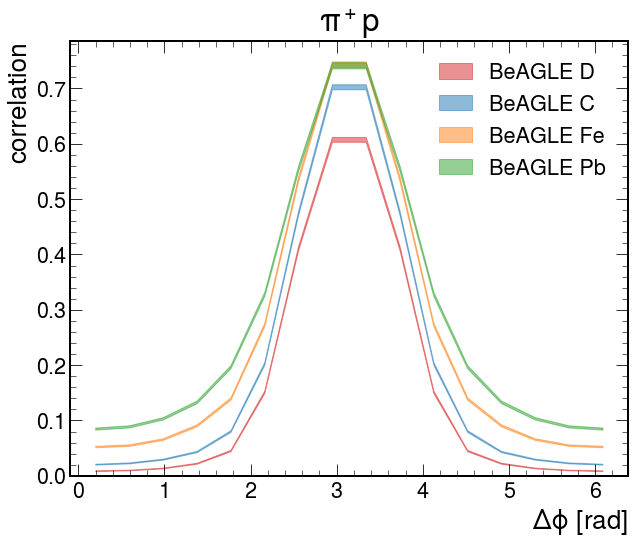

[  143   193   226   433   657  1483  5416 16612]
D 0.633 +- 0.005
[  393   436   597   916  1625  3248  9021 23078]
C 0.750 +- 0.004
[  843   909  1201  1674  2869  5006 10585 21180]
Fe 0.936 +- 0.004
[ 1057  1209  1524  2116  3273  5481  9769 16658]
Pb 1.061 +- 0.004


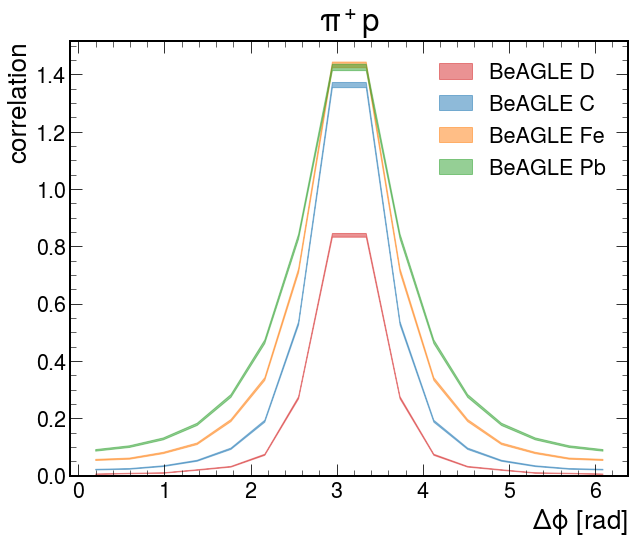

pT2 bins
[  549   660   896  1638  3016  5915 10465 13999]
D 0.956 +- 0.004
[ 1260  1447  1831  2811  4626  8556 14706 20190]
C 1.045 +- 0.004
[ 2523  2741  3333  4229  6484  9823 15095 19514]
Fe 1.229 +- 0.004
[ 3259  3617  4139  5134  7094  9889 13764 16757]
Pb 1.347 +- 0.004


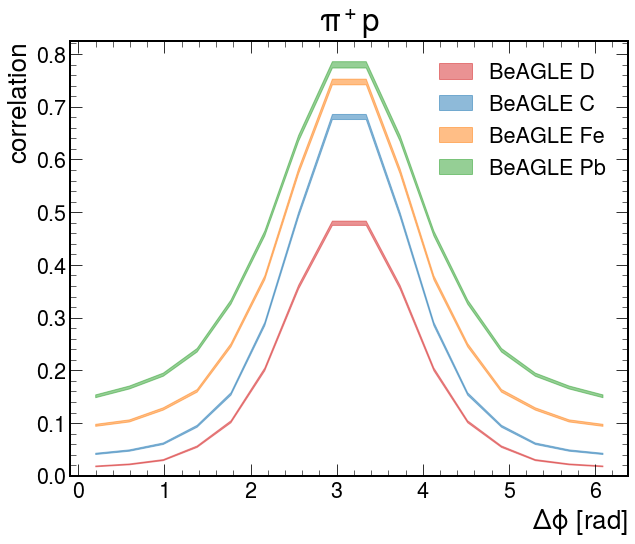

[  253   297   371   711  1546  4642 11133 19872]
D 0.720 +- 0.004
[  625   676   888  1374  2968  6558 14433 25139]
C 0.829 +- 0.004
[ 1348  1433  1711  2592  4457  8275 15449 24139]
Fe 1.003 +- 0.004
[ 1846  1991  2361  3175  4898  8429 13894 19892]
Pb 1.136 +- 0.004


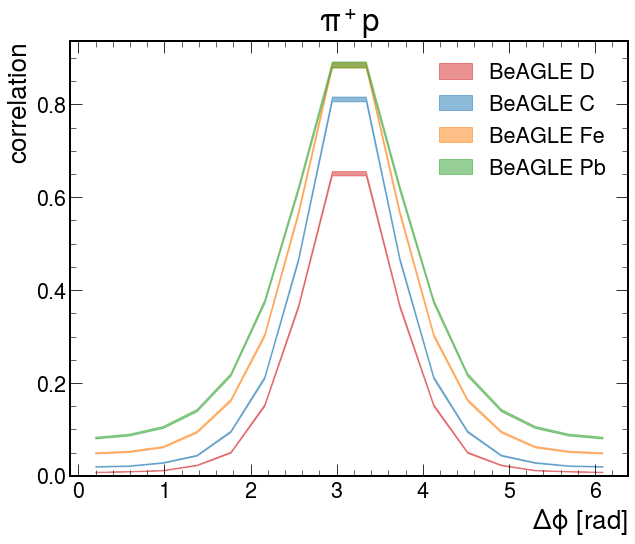

[  58   53   85  139  244  919 3726 9433]
D 0.565 +- 0.006
[   74    81   139   207   436  1511  4829 11423]
C 0.606 +- 0.005
[  167   207   256   390   788  2045  5346 10218]
Fe 0.750 +- 0.006
[ 223  281  328  535  933 1968 4449 8106]
Pb 0.861 +- 0.007


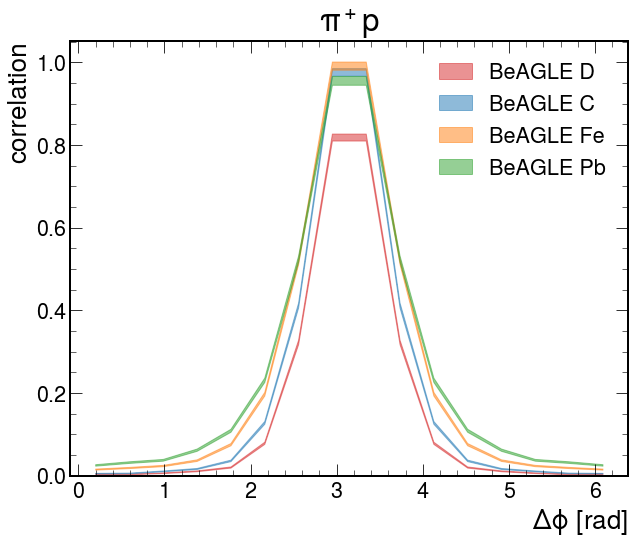

In [120]:
all_BeAGLE[('all', 'pi+')]=[getPrediction(flav="pi+")]
#all_BeAGLE[('all', 'pi-')]=[getPrediction(flav="pi-")]


print("dY bins")
all_BeAGLE[('dY','pi+')]=[getPrediction(f"{v1}<dy and dy<{v2}") for v1, v2 in [(0, 1), (1, 2), (2, 3)]]
print("pT1 bins")
all_BeAGLE[('pT1','pi+')]=[getPrediction(f"{v1}<pT1 and pT1<{v2}", f"{v1}<pT1 and pT1<{v2}") \
                    for v1, v2 in [(0.25, 0.4), (0.4, 0.6), (0.6, 1.0)]]
print("pT2 bins")
all_BeAGLE[('pT2','pi+')]=[getPrediction(f"{v1}<pT2 and pT2<{v2}") for v1, v2 in [(0.25, 0.4), (0.4, 0.6), (0.6, 0.8)]]

In [121]:
simulation_set=all_BeAGLE
for key in all_BeAGLE:
    for i in range(len(simulation_set[key])):
        for A in "D C Fe Pb".split():
            if A not in simulation_set[key][i]:
                continue
            df=simulation_set[key][i][A]
            width=\
                np.sqrt(sum(df.eval(f"C*(phi-{np.pi})**2"))/sum(df.eval("C")))
            simulation_set[key][i][f"{A}_width"]=width
            simulation_set[key][i][f"{A}_dwidth_stat"]=\
                        np.sqrt(sum(df.dCstat**2*(((df.phi-np.pi)**2-width**2)/sum(df.C))**2))/(2*width)
            if A!= "D":
                simulation_set[key][i][f"{A}_broad"]=\
                     np.sqrt(abs(simulation_set[key][i][f"{A}_width"]**2-simulation_set[key][i][f"D_width"]**2))\
                        *np.sign(simulation_set[key][i][f"{A}_width"]-simulation_set[key][i][f"D_width"])
                simulation_set[key][i][f"{A}_dbroad_stat"]\
                          =np.hypot(simulation_set[key][i][f"{A}_width"]*simulation_set[key][i][f"{A}_dwidth_stat"],
                                   simulation_set[key][i][f"D_width"]*simulation_set[key][i][f"D_dwidth_stat"])/\
                                        simulation_set[key][i][f"{A}_broad"]

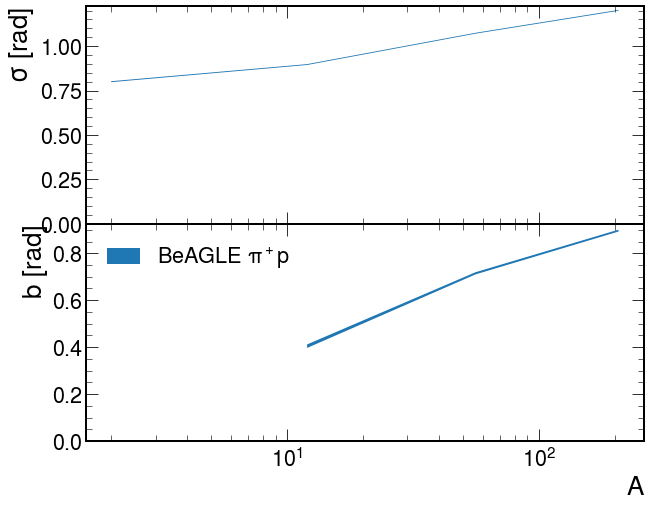

In [122]:
simulation_set=all_BeAGLE
fig, axs=plt.subplots(2,1, sharex='all')
As=[2,12, 56, 207]
names="D C Fe Pb".split()
obs="width broad".split()
for j in range(2):
    plt.sca(axs[j])
    for flav in "pi+".split():
        xs=[]
        ys=[]
        dys=[]
        for i in range(4):
            if i == 0 and j == 1:
                continue
            xs.append(As[i])
            ys.append(simulation_set[('all', flav)][0][f"{names[i]}_{obs[j]}"])
            dys.append(simulation_set[('all', flav)][0][f"{names[i]}_d{obs[j]}_stat"])
        ys=np.array(ys)
        plt.fill_between(xs, ys-dys, ys+dys, label=f"BeAGLE $\\pi^{flav[2]} p$")
plt.xscale("log")
axs[0].set_ylim(0)
axs[1].set_ylim(0)
axs[0].set_ylabel("$\\sigma$ [rad]")
axs[1].set_ylabel("b [rad]")
axs[1].set_xlabel("A")
plt.subplots_adjust(hspace=0)
axs[1].legend(loc='upper left')

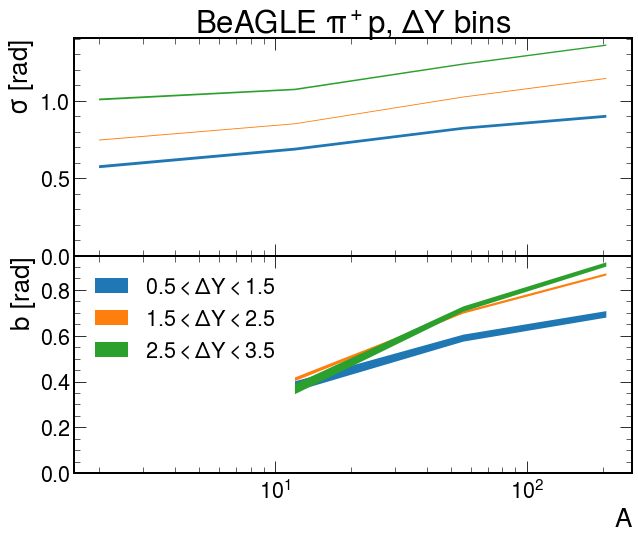

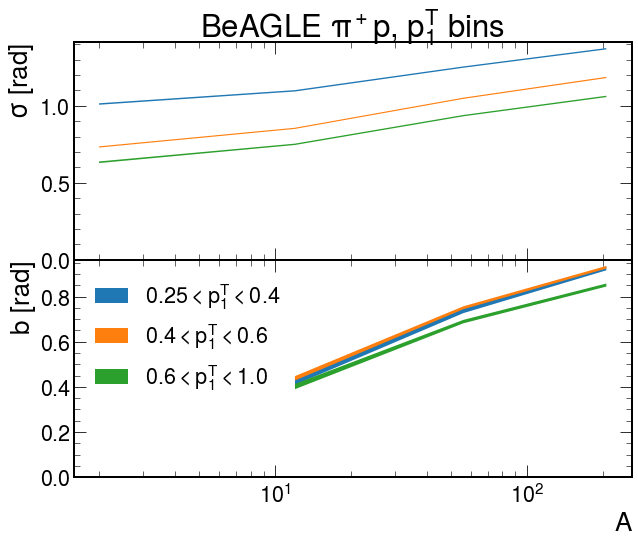

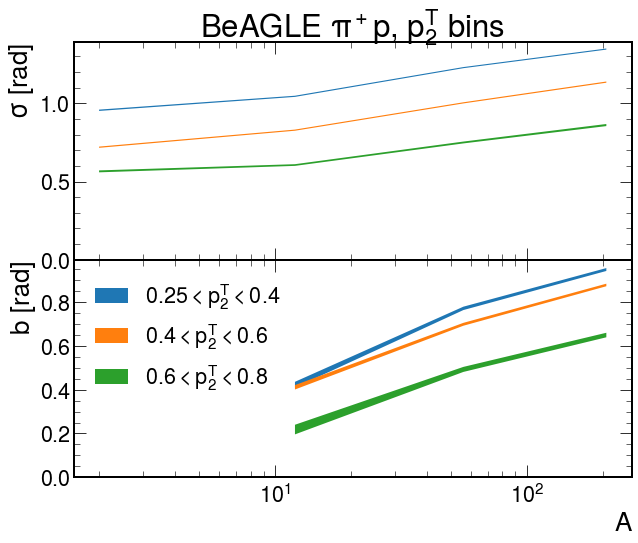

In [125]:
simulation_set=all_BeAGLE
As=[2,12, 56, 207]
names="D C Fe Pb".split()
obs="width broad".split()

vartex={"dY":"\\Delta Y", "pT1":"p^T_1", "pT2":"p^T_2"}
bounds = {"dY": [0.5, 1.5, 2.5, 3.5], "pT1":[0.25, 0.4, 0.6, 1.0], "pT2":[0.25, 0.4, 0.6, 0.8]}
for var in "dY pT1 pT2".split():
    fig, axs=plt.subplots(2,1, sharex='all')
    for bin in range(3):
        for j in range(2):
            plt.sca(axs[j])
            for flav in "pi+".split():
                xs=[]
                ys=[]
                dys=[]
                for i in range(4):
                    if i == 0 and j == 1:
                        continue
                    xs.append(As[i])
                    ys.append(simulation_set[(var, flav)][bin][f"{names[i]}_{obs[j]}"])
                    dys.append(simulation_set[(var, flav)][bin][f"{names[i]}_d{obs[j]}_stat"])
                ys=np.array(ys)
                plt.fill_between(xs, ys-dys, ys+dys, label=f"${bounds[var][bin]}<{vartex[var]}<{bounds[var][bin+1]}$")
    plt.xscale("log")
    axs[0].set_ylim(0)
    axs[1].set_ylim(0)
    axs[0].set_ylabel("$\\sigma$ [rad]")
    axs[1].set_ylabel("b [rad]")
    axs[1].set_xlabel("A")
    plt.legend(loc="upper left")
    plt.subplots_adjust(hspace=0)
    axs[0].set_title(f"BeAGLE $\\pi^{flav[2]} p$, ${vartex[var]}$ bins")
axs[1].legend(loc='upper left')

(array([1.21000e+02, 5.76100e+03, 4.43150e+04, 1.63233e+05, 3.50329e+05,
        4.37517e+05, 3.15364e+05, 1.44338e+05, 3.45420e+04, 1.32900e+03]),
 array([-0.23233977,  0.23541911,  0.703178  ,  1.17093688,  1.63869577,
         2.10645465,  2.57421353,  3.04197242,  3.5097313 ,  3.97749018,
         4.44524907]),
 <BarContainer object of 10 artists>)

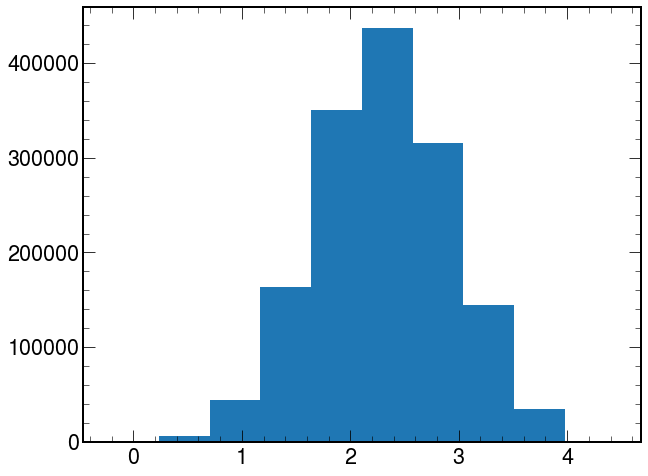

In [124]:
plt.hist(events[('D', 'pi+')].dy)